In [ ]:
import torch 
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from pathlib import Path

# Get absolute paths
data_dir = Path() # input your path
train_path = str(data_dir / 'Training') # paths of images
test_path = str(data_dir / 'Testing') # path of test images

print(os.getcwd())
print(f"Train path: {train_path}")
print(f"Test path: {test_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

])

train_dl = DataLoader(
    datasets.ImageFolder(train_path, tf),
    batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)

test_dl = DataLoader(
    datasets.ImageFolder(test_path, tf),
    batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 16 * 16, 256), nn.ReLU(),nn.Dropout(0.5),
    nn.Linear(256, 4) # Must Be 4 classes
    
    
).to(device)

In [ ]:
opt = optim.AdamW(model.parameters(), 1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model.train()

for epoch in range(25):
    running_loss = 0

    for x, y in train_dl:
        opt.zero_grad()

        loss = loss_fn(model(x.to(device)), y.to(device))
        loss.backward()

        running_loss += loss

        opt.step()

        print(f'Epoch {epoch+1}: loss was {running_loss}')

In [ ]:
model.eval()
test_loss, correct = 0.0, 0

while torch.no_grad():
    for x, y in test_dl:
        x,y = x.to(device), y.to(device)

        logits = model(x)
        test_loss += loss_fn(logits, y).item() * y.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

        test_loss /= len(test_dl.dataset)
        accuracy = correct / len(test_dl.dataset)

        print('Test loss', test_loss, 'Test accuracy', accuracy, '%')
        



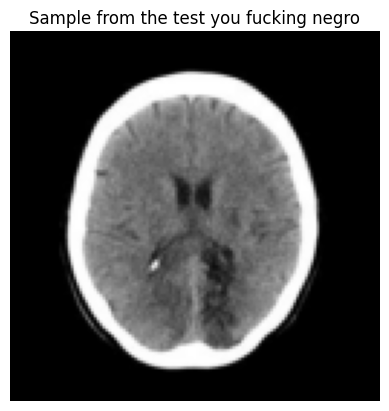

Predicted: notumor, Actual: notumor


In [ ]:
import random

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model.eval()

idx = random.randrange(len(test_dl.dataset))
img, label = test_dl.dataset[idx]

unnorm = img * 0.5 + 0.5
plt.imshow(to_pil_image(unnorm))
plt.axis('off')
plt.title('Sample from the test')
plt.show()

with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    pred = logits.argmax(1).item()


class_names = test_dl.dataset.classes
print(f'Predicted: {class_names[pred]}, Actual: {class_names[label]}')

